In [65]:
import sklearn
import matplotlib.pyplot as plt
from training.sigopt_utils import build_sigopt_name
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import random
from pymatgen.core import Structure
from inference.select_best_models import get_experiment_id


In [66]:
import json

path = "inference/James_Scrap/"

with open(path+'entropy_dft_held_out.json', 'r') as fp:
    formula_to_entropy_dft = json.load(fp)
    
with open(path+'entropy_CGCNN_held_out_best.json', 'r') as fp:
    formula_to_entropy_CGCNN = json.load(fp)
    
with open(path+'entropy_e3nn_held_out_best.json', 'r') as fp:
    formula_to_entropy_e3nn = json.load(fp)

#####
    
with open(path+'entropy_CGCNN_relaxed_held_out_best.json', 'r') as fp:
    formula_to_entropy_CGCNN_relaxed = json.load(fp)
    
with open(path+'entropy_e3nn_relaxed_held_out_best.json', 'r') as fp:
    formula_to_entropy_e3nn_relaxed = json.load(fp)
    
#####
    

In [67]:
model_form_to_entropy = {}

In [68]:

model_form_to_entropy["e3nn"]={}
model_form_to_entropy["CGCNN"]={}

model_form_to_entropy["e3nn"]["unrelaxed"] = formula_to_entropy_e3nn
model_form_to_entropy["CGCNN"]["unrelaxed"] = formula_to_entropy_CGCNN

model_form_to_entropy["e3nn"]["relaxed"] = formula_to_entropy_e3nn_relaxed
model_form_to_entropy["CGCNN"]["relaxed"] = formula_to_entropy_CGCNN_relaxed

In [69]:
def check_if_rocksalt(struct,B_elements):
    struct = Structure.from_dict(struct)
    
    for i in range(len(struct.species)):
        if str(struct.species[i]) in B_elements:
            for j in range(len(struct)):
                diff = struct[i].coords - struct[j].coords
                dist = np.sqrt(np.sum(diff*diff))
                if abs(dist-4.0)<0.1 and struct.species[j]==struct.species[i]:
                    return False
                
    return True

def get_is_rocksalt(df):
    is_rocksalt = []
    
    for i in range(len(df)):
        is_rocksalt.append(check_if_rocksalt(df.iloc[i]["unrelaxed_struct"],df.iloc[i].composition["sites"]["B"]))
    
    return is_rocksalt


def check_if_layered(struct,B_elements):
    struct = Structure.from_dict(struct)
    
    for i in range(len(struct.species)):
        if str(struct.species[i]) in B_elements:
            count_NN = 0
            count_Next_NN = 0
            for j in range(len(struct)):
                diff = struct[i].coords - struct[j].coords
                dist = np.sqrt(np.sum(diff*diff))
                if struct.species[j]==struct.species[i]:
                    if abs(dist-4.0)<0.01:
                        count_NN+=1
                    elif abs(dist-5.6568)<0.01:
                        count_Next_NN +=1
                        
            if count_NN != 2 or count_Next_NN != 1:
                return False
                
    return True

def get_is_layered(df):
    is_layered = []
    
    for i in range(len(df)):
        is_layered.append(check_if_layered(df.iloc[i]["unrelaxed_struct"],df.iloc[i].composition["sites"]["B"]))
    
    return is_layered


def check_if_column(struct,B_elements):
    struct = Structure.from_dict(struct)
    
    for i in range(len(struct.species)):
        if str(struct.species[i]) in B_elements:
            count_NN = 0
            count_Next_NN = 0
            for j in range(len(struct)):
                diff = struct[i].coords - struct[j].coords
                dist = np.sqrt(np.sum(diff*diff))
                if struct.species[j]==struct.species[i]:
                    if abs(dist-4.0)<0.01:
                        count_NN+=1
                    elif abs(dist-5.6568)<0.01:
                        count_Next_NN +=1
    
            if count_NN != 1 or count_Next_NN != 1:
                return False
                
    return True

def get_is_column(df):
    is_col = []
    
    for i in range(len(df)):
        is_col.append(check_if_column(df.iloc[i]["unrelaxed_struct"],df.iloc[i].composition["sites"]["B"]))
    
    return is_col

In [70]:
def get_np_embedding(df):
    curr_embeddings = df["embedding_0"]
    
    arr_list = []
    for embedding in curr_embeddings:
        arr_list.append(np.asarray(embedding[0]))
    np_embedding = np.asarray(arr_list)
    
    return np_embedding

In [71]:
def get_rs_vec(embeddings,pca):
    
    rs_vec = []
    
    forms = set(embeddings.formula)
    embeddings["is_rocksalt"] = get_is_rocksalt(embeddings)
    
    
    for form in forms:
        
        curr_embeddings = embeddings[embeddings["formula"]==form]
        np_embedding = get_np_embedding(curr_embeddings)
        projection = pca.transform(np_embedding)
        
        ref = np.zeros((2))
        
        for i in range(len(curr_embeddings)):
            if curr_embeddings.iloc[i].is_rocksalt:
                rs_pos = projection[i,:]
            else:
                ref += projection[i,:]
        
        curr_dist = rs_pos - ref/5.0
        
        rs_vec.append(curr_dist)
        
        
    rs_vec = np.asarray(rs_vec)
    return rs_vec
    
    
def get_layered_vec(embeddings,pca):
    lay_vec = []
    
    forms = set(embeddings.formula)
    embeddings["is_layered"] = get_is_layered(embeddings)
    
    
    for form in forms:
        
        curr_embeddings = embeddings[embeddings["formula"]==form]
        np_embedding = get_np_embedding(curr_embeddings)
        projection = pca.transform(np_embedding)
        
        ref = np.zeros((2))
        
        for i in range(len(curr_embeddings)):
            if curr_embeddings.iloc[i].is_layered:
                lay_pos = projection[i,:]
            else:
                ref += projection[i,:]
        
        curr_dist = lay_pos - ref/5.0
        
        lay_vec.append(curr_dist)
        
        
    lay_vec = np.asarray(lay_vec)
    return lay_vec

def get_col_vec(embeddings,pca):
    col_vec = []
    
    forms = set(embeddings.formula)
    embeddings["is_column"] = get_is_column(embeddings)
    
    for form in forms:
        
        curr_embeddings = embeddings[embeddings["formula"]==form]
        np_embedding = get_np_embedding(curr_embeddings)
        projection = pca.transform(np_embedding)
        
        #print(curr_embeddings.is_column)
        
        #ref = projection.mean(axis=0)
        ref = np.zeros((2))
        
        for i in range(len(curr_embeddings)):
            if curr_embeddings.iloc[i].is_column:
                col_pos = projection[i,:]
            else:
                ref += projection[i,:]
            
        curr_dist = col_pos - ref/5.0
        
        col_vec.append(curr_dist)
        
        
    col_vec = np.asarray(col_vec)
    return col_vec
    
def get_rs_col_vec(embeddings,pca):
    rs_vec = get_rs_vec(embeddings,pca)
    col_vec = get_col_vec(embeddings,pca)
    
    vec = rs_vec-col_vec
    print(vec)
    
    return vec

In [72]:
sorted_forms = sorted(formula_to_entropy_dft.items(), key=lambda x: x[1])

In [73]:
sorted_forms

[('Ba8Ir4La4O24', 0.16315121970519145),
 ('La4O24Sb4Sr8', 0.1631512200446522),
 ('Ba8La4O24Ru4', 0.16315122213919167),
 ('Mg4O24Re4Sr8', 0.16315123460583358),
 ('Mn4O24Sr8Te4', 0.16315130747742254),
 ('Ba8Ni4O24U4', 0.1631513084529657),
 ('Ba8Ir4O24Sc4', 0.16315143675637425),
 ('O24Ru4Sr8Y4', 0.16315160897152056),
 ('Ba8Mn4O24Re4', 0.16315337381566292),
 ('Ba8O24Re4Y4', 0.16315342868211105),
 ('Ir4O24Sr8Zn4', 0.1631566021780588),
 ('Ni4O24Sr8U4', 0.16315963958383517),
 ('Ba8Co4Mo4O24', 0.16316101791393767),
 ('Ir4O24Sc4Sr8', 0.1631645008660468),
 ('Mo4O24Sr8Zn4', 0.16317199295590715),
 ('Ca8O24Ta4Y4', 0.16320073719281863),
 ('Mn4O24Sr8U4', 0.16320967526502825),
 ('O24Sr8U4Zn4', 0.1632290321875449),
 ('O24Sb4Sc4Sr8', 0.1633228536822596),
 ('Cu4O24Os4Sr8', 0.16475635090708696),
 ('La8Ni4O24Pt4', 0.1656202492643266),
 ('Nb4O24Sr8Y4', 0.16610290961698948),
 ('Fe4O24Sr8Ta4', 0.16614977890621746),
 ('Ba8Fe4O24Ta4', 0.16675934197534598),
 ('Co4Nd8O24Pt4', 0.1669735439277663),
 ('Mn4Ni4O24Tb8'

In [151]:

from matplotlib.patches import FancyArrowPatch

def embeddings_from_file(model_params,test):
    target_prop = "dft_e_hull"
    
    idx = 0
    exp_id = get_experiment_id(model_params, "dft_e_hull")
    sigopt_name = build_sigopt_name(model_params["data"], target_prop, model_params["struct_type"], model_params["interpolation"], model_params["model_type"],contrastive_weight=model_params["contrastive_weight"],training_fraction=model_params["training_fraction"],long_range=False)
    directory = "./best_models/" + param["model_type"] + "/" + sigopt_name + "/" +str(exp_id) + "/" + "best_" + str(idx)
    
    data = pd.read_json(directory + '/' + test + "_embeddings"+"_"+str(0)+".json")
    return data


def find_ind(val_list,target):
    dist = 99999
    curr_index = None
    for i in range(len(val_list)):
        if abs(val_list[i]-target)<dist:
            dist = abs(val_list[i]-target)
            curr_index = i
    return curr_index

def get_pca(param,test,num_comps=5,star_rocksalt=True,square_layered=True,rs_heatmap=True):
    
    if test == "holdout_set_B_sites":
        rs_heatmap=False
    embeddings = embeddings_from_file(param,test)
    print(len(set(embeddings["formula"])))
    np_embedding = get_np_embedding(embeddings)
    print(np_embedding.shape)
    pca = PCA(n_components=2)
    pca.fit(np_embedding)
    projection = pca.transform(np_embedding)
    
    #random.seed(0)
    
    #selected_forms = random.sample(list(embeddings["formula"]), num_comps)
    
    #sorted_forms = sorted(formula_to_entropy_dft.items(), key=lambda x: x[1])
    #random_low_1 = np.random.randint(0, 20)
    #random_low_2 = np.random.randint(0, 20)
    #random_high_1 = np.random.randint(80,100)
    #random_high_2 = np.random.randint(80,100)
    #print([random_low_1,random_low_2,random_high_1,random_high_2])
    #selected_forms = [sorted_forms[random_low_1][0],sorted_forms[random_low_2][0],sorted_forms[random_high_1][0],sorted_forms[random_high_2][0]]
    #colors_lst = [0.0,0.2,0.8,1.0]
    #print(selected_forms)
    
    selected_colors = []
    projection_featured = []
    projection_rs_ordering = []
    projection_lay_ordering = []
    projection_col_ordering = []
    
        
    #print(selected_colors)
    stored_comps = []
    model_entropy = []
    pca_spread = []
    
    pca_vecs = get_rs_col_vec(embeddings,pca)
    
    norm_dist = []
    mean_pos_all = projection.mean(axis=0)
    for i in range(projection.shape[0]):
        norm_dist.append(np.linalg.norm(projection[i,:]-mean_pos_all))
    norm_dist = np.mean(np.asarray(norm_dist))
    
    for form in set(embeddings["formula"]):
        
        model_entropy.append(model_form_to_entropy[param["model_type"]][param["struct_type"]][form])
        stored_comps.append(form)
        
        filtered_embeddings = embeddings[embeddings["formula"]==form]
        np_filtered_embeddings = get_np_embedding(filtered_embeddings)
        curr_projection = pca.transform(np_filtered_embeddings)
        mean_pos = curr_projection.mean(axis=0)
        
        tmp_pca_vals = []
        
        for k in range(len(curr_projection)):
            tmp_pca_vals.append(np.sqrt(np.sum((curr_projection[k,:]-mean_pos)**2)))
            
        pca_spread.append(np.asarray(tmp_pca_vals).mean()/norm_dist)
        
    entrop_args = np.argsort(model_entropy)
    #print(pca_args)
    
    np.random.seed(0)
    min_ind_1 = find_ind(model_entropy,0.163151599)
    mid_ind = find_ind(model_entropy,0.163151599+(1.0-0.163151599)/3.0)
    mid_ind_2 = find_ind(model_entropy,0.163151599+(1.0-0.163151599)*2/3.0)
    #max_ind_1 = pca_args[np.random.randint(60,80)]
    max_ind_2 = find_ind(model_entropy,1.0)
    
    #print()
    print([mid_ind,mid_ind_2,max_ind_2,min_ind_1])
    selected_forms = [stored_comps[mid_ind],stored_comps[mid_ind_2],stored_comps[max_ind_2],stored_comps[min_ind_1]]
    selected_forms = [stored_comps[min_ind_1],stored_comps[mid_ind],stored_comps[mid_ind_2],stored_comps[max_ind_2]]
    selected_forms = selected_forms[::-1]
    
    #print(selected_forms)
    
    colors_lst = [model_form_to_entropy[param["model_type"]][param["struct_type"]][selected_forms[0]],model_form_to_entropy[param["model_type"]][param["struct_type"]][selected_forms[1]],model_form_to_entropy[param["model_type"]][param["struct_type"]][selected_forms[2]],model_form_to_entropy[param["model_type"]][param["struct_type"]][selected_forms[3]]]
    print(colors_lst)
    
    selected_forms = selected_forms[:-4]
    colors_lst = colors_lst[:-4]
        
    for i in range(len(selected_forms)):
        curr_form = selected_forms[i]
        
        
        filtered_embeddings = embeddings[embeddings["formula"]==curr_form]
        filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
        filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
        filtered_embeddings["is_column"] = get_is_column(filtered_embeddings)
        
        np_filtered_embeddings = get_np_embedding(filtered_embeddings)
        curr_projection = pca.transform(np_filtered_embeddings)
        curr_rs_ordering = list(filtered_embeddings["is_rocksalt"])
        curr_lay_ordering = list(filtered_embeddings["is_layered"])
        curr_col_ordering = list(filtered_embeddings["is_column"])
        
        projection_featured.append(curr_projection)
        projection_rs_ordering.append(curr_rs_ordering)
        projection_lay_ordering.append(curr_lay_ordering)
        projection_col_ordering.append(curr_col_ordering)
        
        min_val = 0.163151599
        range_vals = 1.0 - 0.163151599
        
        curr_color = colors_lst[i]*np.ones(curr_projection.shape[0])
        #curr_color = np.ones(curr_projection.shape[0])*(formula_to_entropy_dft[curr_form]-min_val)/range_vals
        #curr_color = np.ones(curr_projection.shape[0])*i
        selected_colors.append(curr_color)
    
        
    
    background_embeddings = embeddings[~embeddings["formula"].isin(selected_forms)]
    np_background_embeddings = get_np_embedding(background_embeddings)
    projection_background = pca.transform(np_background_embeddings)
    
    if not rs_heatmap:
        plt.scatter(projection_background[:,0],projection_background[:,1],c="black",alpha=0.03)
        for i in range(len(projection_featured)):
            has_found = False
            if star_rocksalt and square_layered:
                for j in range(len(projection_featured[i][:,0])):
                    if not projection_rs_ordering[i][j] and not projection_lay_ordering[i][j] and not has_found:
                        curr_label = selected_forms[i]
                        has_found = True
                    else:
                        curr_label = None
                    if projection_rs_ordering[i][j]:
                        plt.scatter(projection_featured[i][j,0],projection_featured[i][j,1],c=selected_colors[i][j],marker='*',s=100,label=curr_label,vmin=0.163151599,vmax=1.0,alpha=0.8,edgecolors= "black")
                    elif projection_lay_ordering[i][j]:
                        plt.scatter(projection_featured[i][j,0],projection_featured[i][j,1],c=selected_colors[i][j],marker='s',s=100,label=curr_label,vmin=0.163151599,vmax=1.0,alpha=0.8,edgecolors= "black")
                    #elif projection_col_ordering[i][j]:
                    #    plt.scatter(projection_featured[i][j,0],projection_featured[i][j,1],c=selected_colors[i][j],marker='P',s=100,label=curr_label,vmin=0.0,vmax=num_comps,alpha=0.8)
                    else:
                        plt.scatter(projection_featured[i][j,0],projection_featured[i][j,1],c=selected_colors[i][j],s=40,label=curr_label,vmin=0.163151599,vmax=1.0,alpha=0.8,edgecolors= "black")

            else:
                plt.scatter(projection_featured[i][:,0],projection_featured[i][:,1],c=selected_colors[i],label=selected_forms[i],vmin=0.163151599,vmax=1.0,alpha=0.8)
                
                
        size = (projection[:,0].max()-projection[:,0].min())*0.04
        
        x_pos = projection[:,0].max() - projection[:,0].min()
        
        y_pos = projection[:,1].max() - projection[:,1].min()
        
        if param["model_type"] == "CGXCNN":
        
            a = 1
    
        else:
            
            net_rs = get_rs_vec(embeddings,pca).mean(axis=0)

            net_layered = get_layered_vec(embeddings,pca).mean(axis=0)
            
            x_start = x_pos*0.70 + projection[:,0].min()-0.15
            y_start = y_pos*0.45+projection[:,1].min()+0.15
            #x_start = -10
            #y_start = -4
            dx = net_rs[0]
            dy = net_rs[1]
            arrow = FancyArrowPatch((x_start, y_start), (x_start + 3*dx, y_start + 3*dy), 
                        arrowstyle='->', mutation_scale=15, color='black',linewidth=2)

            # Add the arrow to the plot
            plt.gca().add_patch(arrow)
            
            x_start = x_pos*0.15 + projection[:,0].min()
            y_start = y_pos*0.15 +projection[:,1].min()
            #x_start = 10
            #y_start = 4
            dx = net_layered[0]
            dy = net_layered[1]
            arrow = FancyArrowPatch((x_start, y_start), (x_start + 3*dx, y_start + 3*dy), 
                        arrowstyle='->', mutation_scale=15, color='black',linewidth=2)

            # Add the arrow to the plot
            plt.gca().add_patch(arrow)
            
            
        plt.gca().set_box_aspect(1)
        plt.colorbar()
        
        plt.xlabel("PCA Component 1",size = 15)
        plt.ylabel("PCA Component 2",size = 15)
        plt.legend(bbox_to_anchor=(2.5, 1))
        #plt.title("Model=" + param["model_type"] + " Struct=" + param["struct_type"] + " Set=" + test,size=15)
        plt.xticks(size=16)
        plt.yticks(size=16)
        plt.savefig("figures/embedding_"+param["model_type"]+".pdf",bbox_inches="tight")
        plt.show()

        

    if rs_heatmap:
        embeddings["is_rocksalt"] = get_is_rocksalt(embeddings)
        np_embedding = get_np_embedding(embeddings)
        projection = pca.transform(np_embedding)
        class_labels = []
        for i in range(len(embeddings)):
            if embeddings.iloc[i].is_rocksalt:
                class_labels.append(1)
            else:
                class_labels.append(0)
        class_labels = np.asarray(class_labels)
        
        x = projection[:,0]
        y = projection[:,1]
        
        bins_x = np.linspace(min(x), max(x), num=25)
        bins_y = np.linspace(min(y), max(y), num=25)
        
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=(bins_x, bins_y))

        class_probabilities = np.zeros((len(bins_x) - 1, len(bins_y) - 1))

        for i in range(len(bins_x) - 1):
            for j in range(len(bins_y) - 1):
                mask = (x >= bins_x[i]) & (x < bins_x[i + 1]) & (y >= bins_y[j]) & (y < bins_y[j + 1])
                if np.sum(mask) > 0:
                    bin_class_prob = np.mean(class_labels[mask])
                    class_probabilities[i, j] = bin_class_prob
                else:
                    # If there are no data points in this bin, set the class probability to NaN
                    class_probabilities[i, j] = np.nan

        # Create the heatmap plot based on class probabilities with a single colormap
        cmap = plt.get_cmap('viridis')
        cmap.set_bad(color='white')  # Set color for bins with no data to white

        plt.imshow(class_probabilities.T, extent=(bins_x[0], bins_x[-1], bins_y[0], bins_y[-1]), origin='lower', cmap=cmap, vmin=0, vmax=0.8)
        plt.colorbar(label='Class Probability')
        plt.title("Model=" + param["model_type"] + " Struct=" + param["struct_type"] + " Set=" + test,size=15)

        plt.show()
        
        np_embedding_filt = get_np_embedding(embeddings[embeddings["is_rocksalt"]==True])
        projection_filt = pca.transform(np_embedding_filt)
        plt.scatter(projection[:,0],projection[:,1],alpha=0.2)
        plt.scatter(projection_filt[:,0],projection_filt[:,1],alpha=0.2)
        
        print(projection_filt.shape[0]/projection.shape[0])
        plt.show()

    
    return model_entropy, pca_spread, pca_vecs
    
    

In [152]:
all_params = [
{
    "data":"data/",
    "struct_type": "unrelaxed",
    "interpolation": False,
    "model_type": "CGCNN",
    "contrastive_weight":1.0,
    "training_fraction":1.0,
    "long_range":False
},
    
    

{
    "data":"data/",
    "struct_type": "unrelaxed",
    "interpolation": False,
    "model_type": "e3nn",
    "contrastive_weight":1.0,
    "training_fraction":1.0,
    "long_range":False
},
    
]

all_tests = ["holdout_set_B_sites"]

dft_e_hull_htvs_data_unrelaxed_CGCNN
100
(600, 256)
[[-6.20652404e-02 -1.92380738e-01]
 [ 1.43052434e-02 -1.90843178e-01]
 [-1.30543171e-01 -1.09099053e-01]
 [-1.71783054e-02 -4.19370281e-01]
 [-2.21745825e-02 -1.80942296e-01]
 [-1.55444923e-01 -1.31575166e-01]
 [ 1.87411137e-02 -7.44546369e-03]
 [-1.52670246e-01 -2.48575277e-01]
 [ 1.86336448e-01 -4.10434006e-01]
 [-3.95937018e-02 -9.54280138e-02]
 [ 1.04383304e-01 -1.02152195e-01]
 [-6.32612885e-02 -1.09489309e-01]
 [ 3.24959271e-02  3.50412777e-02]
 [-2.08332558e-01 -3.92182866e-01]
 [-1.37073491e-01 -1.61156545e-01]
 [-5.55633358e-02 -8.85842500e-01]
 [ 2.57848299e-01  1.29364923e-01]
 [ 7.27514560e-02 -2.51781979e-01]
 [ 1.99415945e-01  2.18871228e-03]
 [ 2.45601073e-02 -3.00813029e-01]
 [-3.60362658e-01 -1.88279542e-01]
 [ 6.26917636e-02 -3.54153970e-01]
 [ 7.55839256e-02 -2.14340924e-01]
 [ 3.04604521e-02 -2.29426312e-01]
 [ 6.23330034e-03 -7.48777384e-02]
 [-2.08255149e-01 -2.00478114e-01]
 [ 4.47497911e-03 -2.25512974e-02]
 [-

2024-01-27 20:20:31,948|WARNING|No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


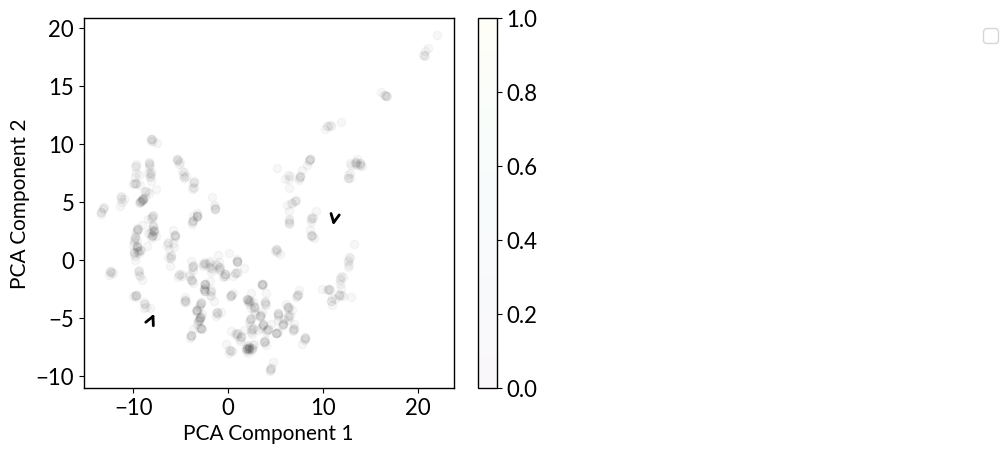

dft_e_hull_htvs_data_unrelaxed_e3nn
100
(600, 128)
[[-7.49904296e-02  2.08326996e-01]
 [-2.40798057e-01  1.75648372e-01]
 [-2.40664776e-01  5.57781788e-02]
 [-3.79767370e-01 -5.82819864e-02]
 [-2.61808252e-01  6.90194323e-02]
 [-1.02152728e-01 -2.46232699e-02]
 [-1.29272568e-01 -1.16021983e-01]
 [-1.63224144e-01  5.44075406e-02]
 [-3.93204467e-01  3.79116827e-02]
 [ 1.01481183e-02  3.09106407e-02]
 [-2.91447868e-01  1.23700452e-01]
 [-4.40656702e-02  8.03115255e-02]
 [ 1.64124273e-02  5.90643742e-02]
 [-2.07446592e-01  8.82828075e-02]
 [ 3.98627332e-02  2.53338380e-03]
 [-3.03558009e-01  2.50716439e-01]
 [-2.49599558e-01  1.02737062e-01]
 [-1.24962882e-01  1.05053821e-01]
 [-1.03258298e-01  4.46390980e-02]
 [-2.35924539e-02  1.93897575e-02]
 [-4.72738566e-02  6.68635841e-02]
 [-2.46549636e-01  6.25708639e-02]
 [-1.27474627e-01  1.11625411e-01]
 [-7.11794179e-02  4.68873042e-02]
 [-2.42827296e-01  2.07257426e-01]
 [-1.18372006e-01  1.12647250e-01]
 [-4.61816498e-03  5.61183462e-03]
 [ 1

2024-01-27 20:20:43,445|WARNING|No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


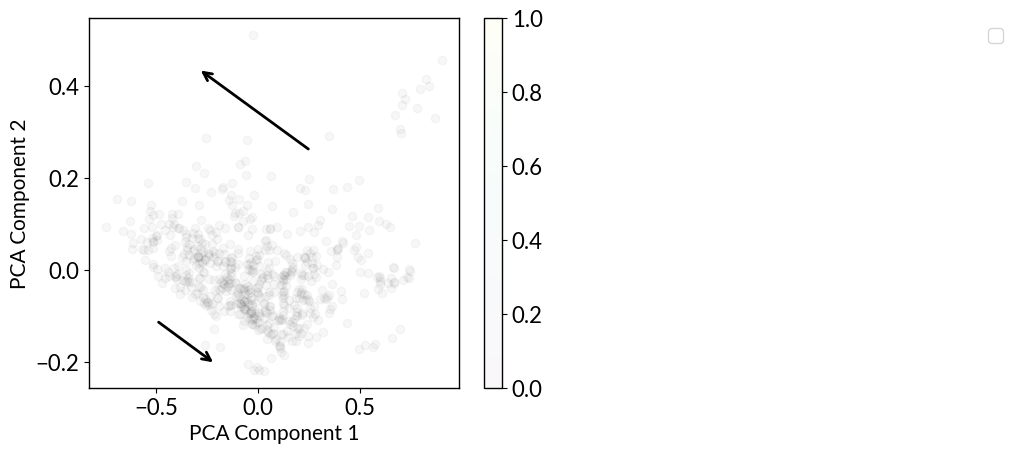

In [153]:
for param in all_params:
    for test in all_tests:
        get_pca(param,test)

In [116]:
all_params = [
{
    "data":"data/",
    "struct_type": "unrelaxed",
    "interpolation": False,
    "model_type": "CGCNN",
    "contrastive_weight":1.0,
    "training_fraction":1.0,
    "long_range":False
},
    
    

{
    "data":"data/",
    "struct_type": "unrelaxed",
    "interpolation": False,
    "model_type": "e3nn",
    "contrastive_weight":1.0,
    "training_fraction":1.0,
    "long_range":False
},
    
]

all_tests = ["holdout_set_B_sites"]

dft_e_hull_htvs_data_relaxed_CGCNN
100
(600, 124)
[[-3.67594310e-01  5.02964103e-01]
 [ 8.69043466e-01 -4.71486651e+00]
 [-2.14183629e-01 -5.41826996e-01]
 [-2.24242205e-01  2.13990628e-01]
 [-5.24133884e-02  1.96954331e-01]
 [-7.45742361e-01 -9.60485895e-01]
 [ 1.71735039e+00  8.04097595e-01]
 [-2.00051019e-01  9.78361351e-02]
 [-1.28595170e+00 -6.39974162e-01]
 [ 2.02222117e-02 -9.03123537e-02]
 [ 1.50235269e+00  1.75495316e+00]
 [ 7.61607239e-02 -2.22640387e-02]
 [ 3.83594191e-01  8.16067208e-04]
 [-2.03218962e-02  2.19057967e-01]
 [-1.62521916e-02 -5.49809524e-01]
 [-8.52759391e-01 -2.90675749e-01]
 [ 2.73378074e+00 -5.15479084e+00]
 [ 4.44804298e-01 -1.41375484e+00]
 [ 2.23552363e-01  4.30318295e-01]
 [ 1.16812211e-01 -1.97610272e-01]
 [ 6.23478681e-01 -1.22085452e+00]
 [-1.97918820e-01 -1.01275976e+00]
 [-3.82035623e-01  1.13956372e+00]
 [-4.60724505e-01  3.87407146e-01]
 [ 5.06563346e-01  5.21745527e-01]
 [-7.85880511e-01  8.84545340e-01]
 [-2.78161752e-02  1.78985139e-01]
 [-8.

/tmp/ipykernel_64384/2022272947.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_64384/2022272947.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
/tmp/ipykernel_64384/2022272947.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

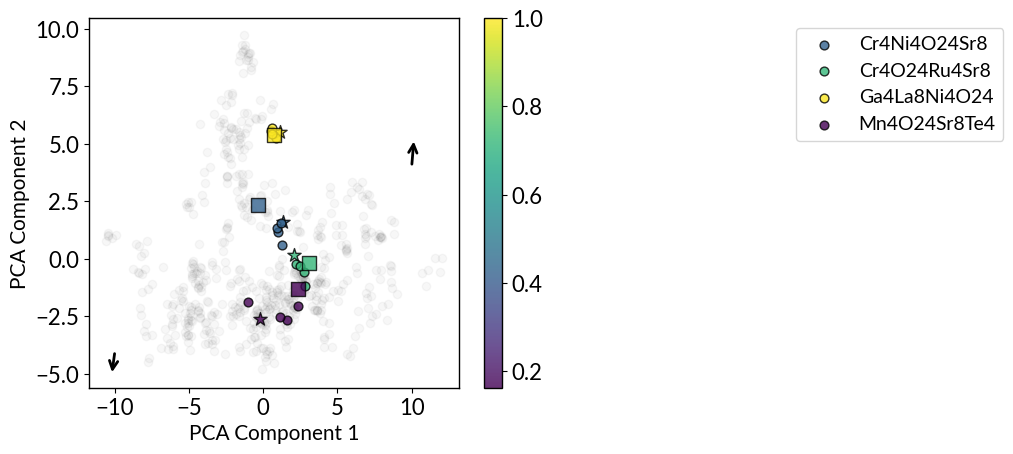

dft_e_hull_htvs_data_relaxed_e3nn
100
(600, 128)
[[ 5.41886941e-01 -7.18600344e-01]
 [-4.08704013e-01 -1.06937304e-01]
 [-1.83730977e-01 -1.21877723e-01]
 [-3.97155651e-01  8.12091453e-02]
 [-1.22360651e-01 -7.90902093e-02]
 [-1.05772727e-01 -2.91281424e-02]
 [-5.51865002e-02 -1.43901693e-01]
 [ 2.08558325e-01 -3.97414651e-01]
 [-7.94315605e-02 -3.59382934e-01]
 [ 4.86610533e-02 -1.84610053e-01]
 [-9.56777686e-02 -2.29300851e-01]
 [ 3.38800941e-02 -2.64874202e-01]
 [-3.94815206e-02  1.91750315e-01]
 [ 1.00179440e-01 -2.91121381e-01]
 [ 4.34665101e-01 -4.83634873e-01]
 [ 3.69828725e-02 -1.20899116e-01]
 [-2.82510509e-01  1.48955567e-02]
 [ 2.54348835e-01 -3.22618704e-01]
 [ 8.70812666e-02 -1.29580749e-01]
 [ 2.73503893e-01 -4.97534908e-01]
 [ 8.21818560e-02 -1.72348339e-01]
 [-1.34941593e-01 -2.24997180e-02]
 [-2.71179181e-01 -3.71711928e-02]
 [-3.72125805e-01  1.94180875e-01]
 [ 1.61318542e-01 -4.63002581e-01]
 [ 2.41604893e-02 -2.52682092e-01]
 [ 1.19904968e-01 -1.04166651e-01]
 [ 3.1

/tmp/ipykernel_64384/2022272947.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_64384/2022272947.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
/tmp/ipykernel_64384/2022272947.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

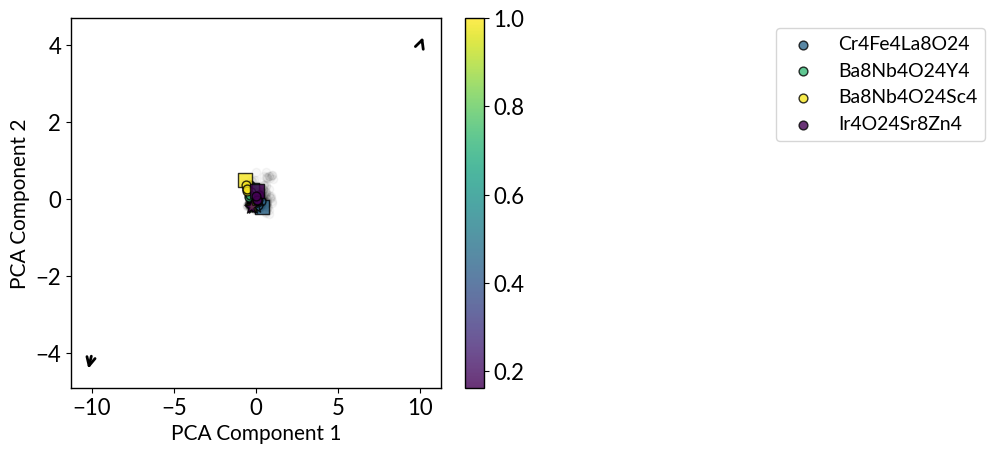

In [53]:
for param in all_params:
    for test in all_tests:
        get_pca(param,test)

In [11]:
for param in all_params:
    for test in all_tests:
        print(param)
        print(test)

{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 1.0, 'long_range': False}
holdout_set_B_sites
{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': False, 'model_type': 'e3nn', 'contrastive_weight': 1.0, 'training_fraction': 1.0, 'long_range': False}
holdout_set_B_sites


In [12]:
print(all_params[0])

{'data': 'data/', 'struct_type': 'unrelaxed', 'interpolation': False, 'model_type': 'CGCNN', 'contrastive_weight': 1.0, 'training_fraction': 1.0, 'long_range': False}


In [13]:
print(all_tests[0])

holdout_set_B_sites


In [14]:
param = all_params[0]
test = all_tests[0]

dft_e_hull_htvs_data_unrelaxed_CGCNN
['La8Ni4O24Pt4', 'Ba8Nb4O24Sc4', 'Cu4Nd8O24Sn4', 'Cu4La8O24Rh4', 'Mn4O24Pr8Rh4']


/tmp/ipykernel_4042638/4134344485.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_4042638/4134344485.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
/tmp/ipykernel_4042638/4134344485.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

[array([0.00294994, 0.00294994, 0.00294994, 0.00294994, 0.00294994,
       0.00294994]), array([0.0261528, 0.0261528, 0.0261528, 0.0261528, 0.0261528, 0.0261528]), array([0.30928851, 0.30928851, 0.30928851, 0.30928851, 0.30928851,
       0.30928851]), array([0.81522083, 0.81522083, 0.81522083, 0.81522083, 0.81522083,
       0.81522083]), array([0.96527991, 0.96527991, 0.96527991, 0.96527991, 0.96527991,
       0.96527991])]


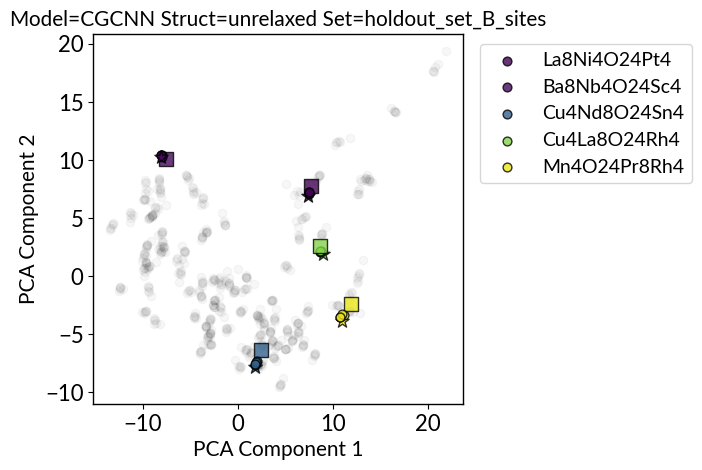

([0.9491603519673195,
  0.7223813961301209,
  0.16315337381566294,
  0.8690689645311952,
  0.18037820231160717,
  0.8648873975006715,
  0.16316101791393767,
  0.16702490223507227,
  0.1815330082259183,
  0.16675934197534598,
  0.7933926411460162,
  0.35410326085572813,
  0.96423348371594,
  0.2714611788382856,
  0.3301990232849606,
  0.1631596395838352,
  0.21889185457814006,
  0.8627237032118008,
  0.3333123100585972,
  0.9111377754744461,
  0.17113231363588222,
  0.7961521080795847,
  0.27450259669779636,
  0.17903405234413922,
  0.778451092141434,
  0.1734518828020697,
  0.17154120956915053,
  0.788963922565016,
  0.7677957250309655,
  0.16315160897152056,
  0.16315122213919167,
  0.18503752800969347,
  0.1916413675226691,
  0.16315130747742254,
  0.8473074537612363,
  0.16320967526502825,
  0.3007861978772566,
  0.16787107309682264,
  0.8715125953569075,
  0.18155202528964995,
  0.1631513084529657,
  0.42249429329768223,
  0.5921675570706704,
  0.1633228536822596,
  0.8453678501729

In [15]:
get_pca(param,test)

dft_e_hull_htvs_data_unrelaxed_CGCNN
100
(600, 256)
[[-6.20652404e-02 -1.92380738e-01]
 [ 1.43052434e-02 -1.90843178e-01]
 [-1.30543171e-01 -1.09099053e-01]
 [-1.71783054e-02 -4.19370281e-01]
 [-2.21745825e-02 -1.80942296e-01]
 [-1.55444923e-01 -1.31575166e-01]
 [ 1.87411137e-02 -7.44546369e-03]
 [-1.52670246e-01 -2.48575277e-01]
 [ 1.86336448e-01 -4.10434006e-01]
 [-3.95937018e-02 -9.54280138e-02]
 [ 1.04383304e-01 -1.02152195e-01]
 [-6.32612885e-02 -1.09489309e-01]
 [ 3.24959271e-02  3.50412777e-02]
 [-2.08332558e-01 -3.92182866e-01]
 [-1.37073491e-01 -1.61156545e-01]
 [-5.55633358e-02 -8.85842500e-01]
 [ 2.57848299e-01  1.29364923e-01]
 [ 7.27514560e-02 -2.51781979e-01]
 [ 1.99415945e-01  2.18871228e-03]
 [ 2.45601073e-02 -3.00813029e-01]
 [-3.60362658e-01 -1.88279542e-01]
 [ 6.26917636e-02 -3.54153970e-01]
 [ 7.55839256e-02 -2.14340924e-01]
 [ 3.04604521e-02 -2.29426312e-01]
 [ 6.23330034e-03 -7.48777384e-02]
 [-2.08255149e-01 -2.00478114e-01]
 [ 4.47497911e-03 -2.25512974e-02]
 [-

/tmp/ipykernel_64384/3978491814.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_64384/3978491814.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
/tmp/ipykernel_64384/3978491814.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

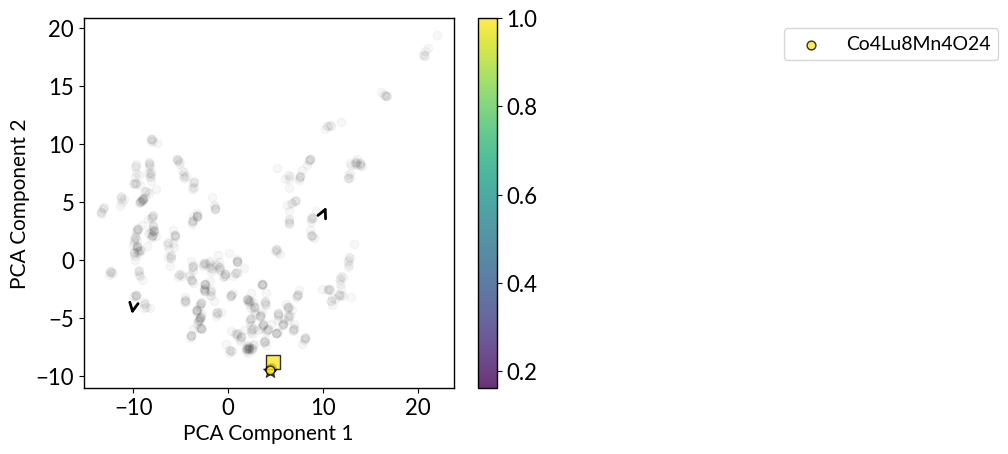

dft_e_hull_htvs_data_unrelaxed_e3nn
100
(600, 128)
[[-7.49904296e-02  2.08326996e-01]
 [-2.40798057e-01  1.75648372e-01]
 [-2.40664776e-01  5.57781788e-02]
 [-3.79767370e-01 -5.82819864e-02]
 [-2.61808252e-01  6.90194323e-02]
 [-1.02152728e-01 -2.46232699e-02]
 [-1.29272568e-01 -1.16021983e-01]
 [-1.63224144e-01  5.44075406e-02]
 [-3.93204467e-01  3.79116827e-02]
 [ 1.01481183e-02  3.09106407e-02]
 [-2.91447868e-01  1.23700452e-01]
 [-4.40656702e-02  8.03115255e-02]
 [ 1.64124273e-02  5.90643742e-02]
 [-2.07446592e-01  8.82828075e-02]
 [ 3.98627332e-02  2.53338380e-03]
 [-3.03558009e-01  2.50716439e-01]
 [-2.49599558e-01  1.02737062e-01]
 [-1.24962882e-01  1.05053821e-01]
 [-1.03258298e-01  4.46390980e-02]
 [-2.35924539e-02  1.93897575e-02]
 [-4.72738566e-02  6.68635841e-02]
 [-2.46549636e-01  6.25708639e-02]
 [-1.27474627e-01  1.11625411e-01]
 [-7.11794179e-02  4.68873042e-02]
 [-2.42827296e-01  2.07257426e-01]
 [-1.18372006e-01  1.12647250e-01]
 [-4.61816498e-03  5.61183462e-03]
 [ 1

/tmp/ipykernel_64384/3978491814.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_rocksalt"] = get_is_rocksalt(filtered_embeddings)
/tmp/ipykernel_64384/3978491814.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_embeddings["is_layered"] = get_is_layered(filtered_embeddings)
/tmp/ipykernel_64384/3978491814.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

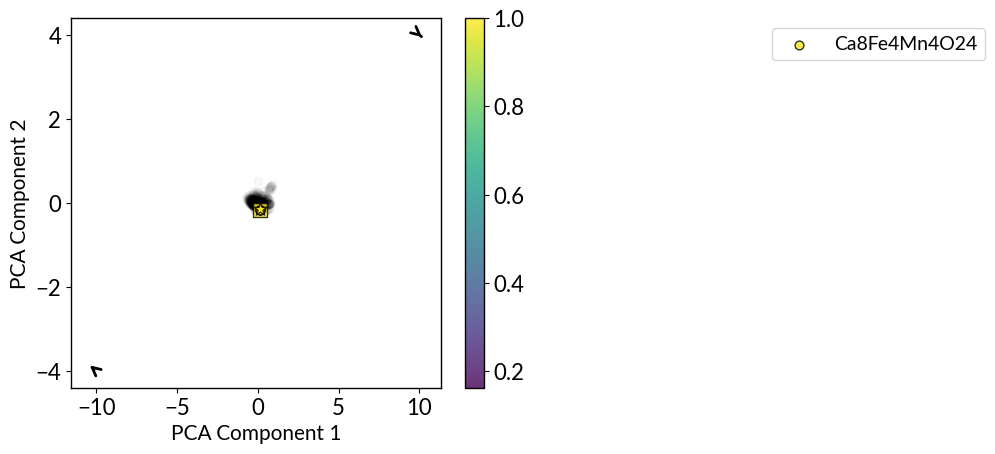

In [117]:
param = all_params[0]
test = all_tests[0]
CGCNN_entropy, pca_CGCNN,CGCNN_vecs = get_pca(param,test)
param = all_params[1]
test = all_tests[0]
e3nn_entropy, pca_e3nn, e3nn_vecs = get_pca(param,test)

In [118]:
print(np.asarray(pca_CGCNN).mean())

0.02830097497535846


In [119]:
print(np.asarray(pca_CGCNN).mean())

0.02830097497535846


In [63]:
0.11548607/0.02830097

4.080639992198147

In [64]:
np.corrcoef(CGCNN_entropy,pca_CGCNN)

array([[ 1.       , -0.0819951],
       [-0.0819951,  1.       ]])

In [56]:
np.corrcoef(e3nn_entropy,pca_e3nn)

array([[ 1.        , -0.46149954],
       [-0.46149954,  1.        ]])

In [57]:
np.corrcoef(CGCNN_entropy,pca_CGCNN)

array([[ 1.        , -0.47660795],
       [-0.47660795,  1.        ]])

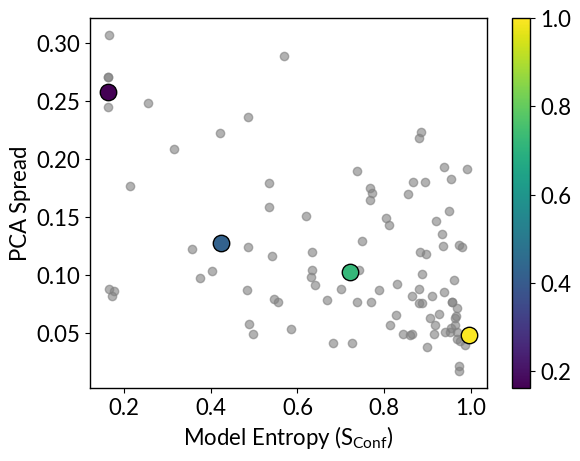

In [45]:
plt.scatter(CGCNN_entropy,pca_CGCNN,color="grey",alpha=0.6)
data = [70, 25, 97, 99]
for i in range(len(data)):
    plt.scatter(CGCNN_entropy[data[i]],pca_CGCNN[data[i]],c=CGCNN_entropy[data[i]],s=140,vmin=0.16315159,vmax=1.0,edgecolor="black")
plt.colorbar()
#plt.yticks([0.02,0.04,0.06,0.08])
plt.xlabel("Model Entropy ($S_{Conf}$)")
plt.ylabel("PCA Spread")
#plt.colorbar()
plt.savefig("figures/embedding_"+"CGCNN_Spread_Relaxed"+".pdf",bbox_inches="tight")


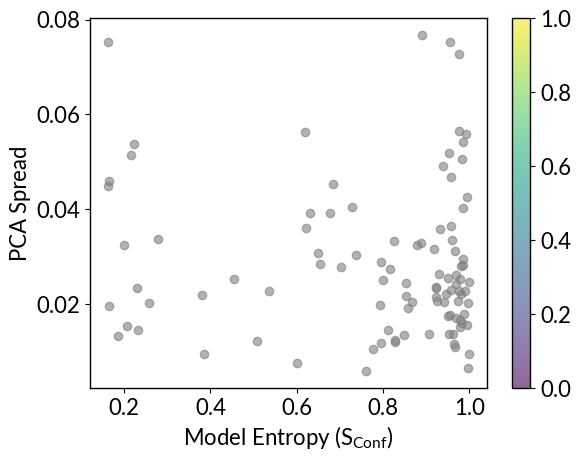

In [131]:
plt.scatter(CGCNN_entropy,pca_CGCNN,color="grey",alpha=0.6)
#data = [81, 17, 73, 79]
data = [73]
for i in range(0):
    plt.scatter(CGCNN_entropy[data[i]],pca_CGCNN[data[i]],c=CGCNN_entropy[data[i]],s=140,vmin=0.16315159,vmax=1.0,edgecolor="black")
plt.colorbar()
plt.yticks([0.02,0.04,0.06,0.08])
plt.xlabel("Model Entropy ($S_{Conf}$)")
plt.ylabel("PCA Spread")
plt.savefig("figures/embedding_"+"CGCNN_Spread_Unrelaxed"+".pdf",bbox_inches="tight")


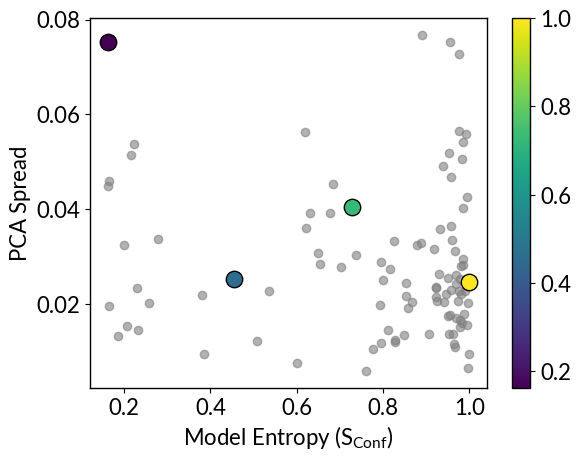

In [40]:
plt.scatter(CGCNN_entropy,pca_CGCNN,color="grey",alpha=0.6)
data = [81, 17, 73, 79]
for i in range(len(data)):
    plt.scatter(CGCNN_entropy[data[i]],pca_CGCNN[data[i]],c=CGCNN_entropy[data[i]],s=140,vmin=0.16315159,vmax=1.0,edgecolor="black")
plt.colorbar()
plt.yticks([0.02,0.04,0.06,0.08])
plt.xlabel("Model Entropy ($S_{Conf}$)")
plt.ylabel("PCA Spread")
plt.savefig("figures/embedding_"+"CGCNN_Spread_Unrelaxed"+".pdf",bbox_inches="tight")


Text(0, 0.5, 'PCA Spread')

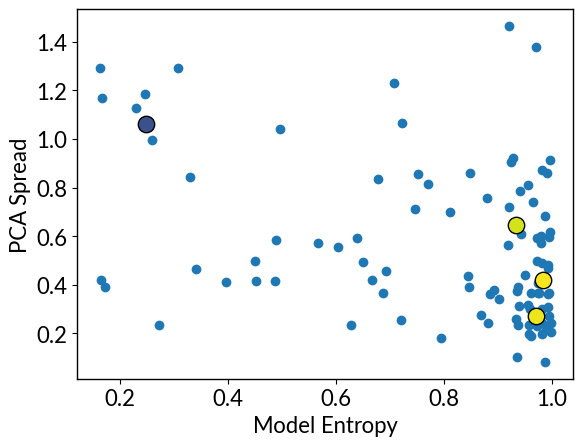

In [44]:
plt.scatter(CGCNN_entropy,pca_CGCNN)
data = [45, 7, 60, 71]
for i in range(len(data)):
    plt.scatter(CGCNN_entropy[data[i]],pca_CGCNN[data[i]],c=CGCNN_entropy[data[i]],s=140,vmin=0,vmax=1.0,edgecolor="black")
plt.xlabel("Model Entropy")
plt.ylabel("PCA Spread")

In [325]:
for i in range(len(dft_entropy)):
    if dft_entropy[i]>0.4 and pca_e3nn[i] > 0.12:
        print(i)
        print(dft_entropy[i])

56
0.5067853337554307
87
0.6276688908832685
89
0.6364303592076822


(array([41.,  8.,  4.,  5.,  7.,  5.,  5.,  6.,  7., 12.]),
 array([0.16315122, 0.24672579, 0.33030037, 0.41387494, 0.49744952,
        0.58102409, 0.66459866, 0.74817324, 0.83174781, 0.91532239,
        0.99889696]),
 <BarContainer object of 10 artists>)

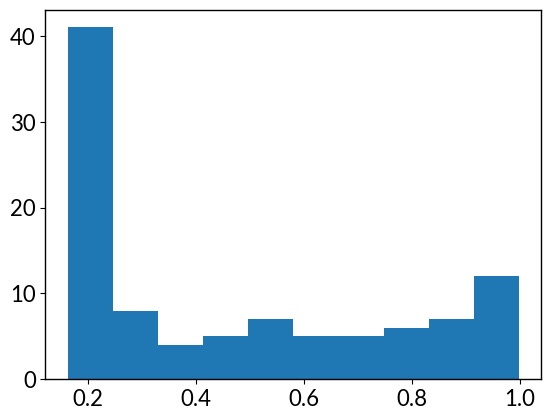

In [326]:
plt.hist(dft_entropy)

In [346]:
e3nn_entropy.sort()

In [347]:
e3nn_entropy

[0.16315122041029811,
 0.16316327414438642,
 0.16316928868293668,
 0.16317622715465482,
 0.16320642174683414,
 0.1632096940628725,
 0.16330531925710345,
 0.16331957227160038,
 0.1635620400844807,
 0.1637486945648951,
 0.1639111215634027,
 0.16394594253549458,
 0.16404436626489727,
 0.16407531380177068,
 0.16426096003875615,
 0.16469138004692874,
 0.16476184531107665,
 0.16511547660165216,
 0.16593560849460062,
 0.16624054476059297,
 0.16679842582777296,
 0.16813355242692332,
 0.17173740535465912,
 0.17247675671753324,
 0.17516422300624843,
 0.17867334326730433,
 0.18026633066053008,
 0.1805679036762749,
 0.18121147594727577,
 0.18522802822988851,
 0.18532095186927783,
 0.18536586549049955,
 0.19727181204253566,
 0.19930215421969277,
 0.2107416714723232,
 0.21155668533755564,
 0.21178454297432214,
 0.21632362879334302,
 0.2252575098396641,
 0.23849066617546488,
 0.24257768955676462,
 0.2503357165841507,
 0.25416282747323915,
 0.257876190526095,
 0.2757684713740911,
 0.2822814549063306,


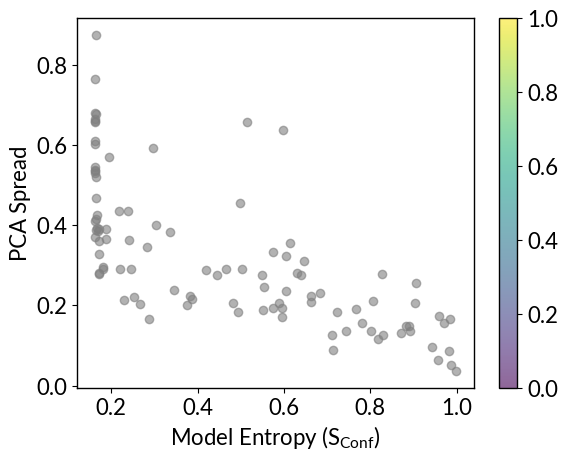

In [138]:
plt.scatter(e3nn_entropy,pca_e3nn,color="grey",alpha=0.6)



#data = [22, 82, 9, 79]
data = [9,82]

for i in range(0):
    plt.scatter(e3nn_entropy[data[i]],pca_e3nn[data[i]],c=e3nn_entropy[data[i]],s=140,vmin=0.16315159,vmax=1.0,edgecolor="black",label=str(i))
plt.xlabel("Model Entropy ($S_{Conf}$)")
plt.ylabel("PCA Spread")
plt.colorbar()
#plt.legend()
plt.savefig("figures/embedding_"+"e3nn_Spread_Unrelaxed"+".pdf",bbox_inches="tight")


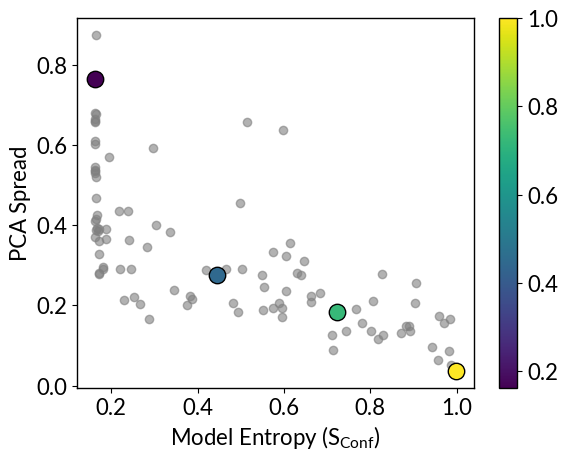

In [42]:
plt.scatter(e3nn_entropy,pca_e3nn,color="grey",alpha=0.6)



data = [22, 82, 9, 79]


for i in range(len(data)):
    plt.scatter(e3nn_entropy[data[i]],pca_e3nn[data[i]],c=e3nn_entropy[data[i]],s=140,vmin=0.16315159,vmax=1.0,edgecolor="black",label=str(i))
plt.xlabel("Model Entropy ($S_{Conf}$)")
plt.ylabel("PCA Spread")
plt.colorbar()
#plt.legend()
plt.savefig("figures/embedding_"+"e3nn_Spread_Unrelaxed"+".pdf",bbox_inches="tight")


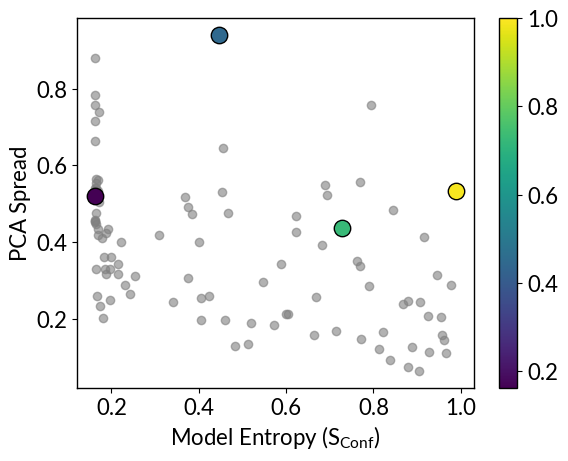

In [46]:
plt.scatter(e3nn_entropy,pca_e3nn,color="grey",alpha=0.6)



data =[54, 17, 96, 92]

for i in range(len(data)):
    plt.scatter(e3nn_entropy[data[i]],pca_e3nn[data[i]],c=e3nn_entropy[data[i]],s=140,vmin=0.16315159,vmax=1.0,edgecolor="black")
plt.xlabel("Model Entropy ($S_{Conf}$)")
plt.ylabel("PCA Spread")
plt.colorbar()
plt.savefig("figures/embedding_"+"e3nn_Spread_Relaxed"+".pdf",bbox_inches="tight")


In [354]:
e3nn_vecs_sqrd = e3nn_vecs**2

In [355]:
e3nn_vecs_sum = e3nn_vecs_sqrd.sum(axis=1)

(-0.02, 0.2)

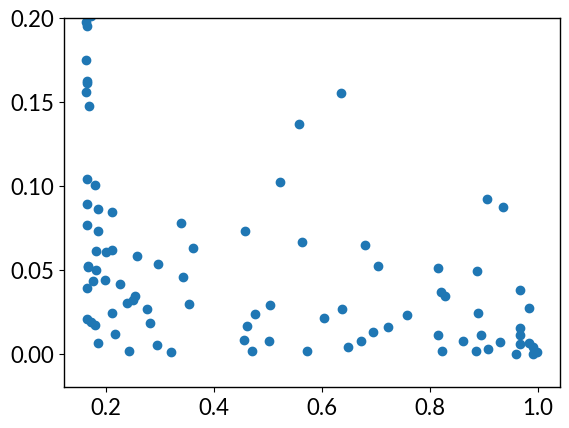

In [361]:
plt.scatter(e3nn_entropy,e3nn_vecs_sum)
plt.ylim(-0.02,0.20)

In [213]:
print(len(dft_entropy))

100


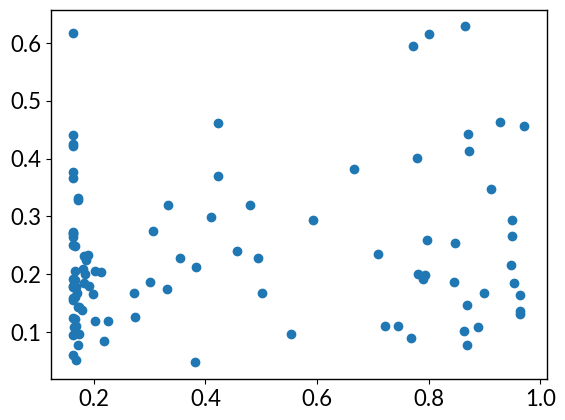

In [120]:
plt.scatter(dft_entropy,pca_CGCNN)

In [121]:
np.mean(pca_CGCNN)

0.2316625316560871

In [122]:
np.mean(pca_e3nn)

0.08666403864879933

In [123]:
[pca_e3nn[0]]

[0.07901145073799141]

In [158]:
print(len(dft_entropy))

500


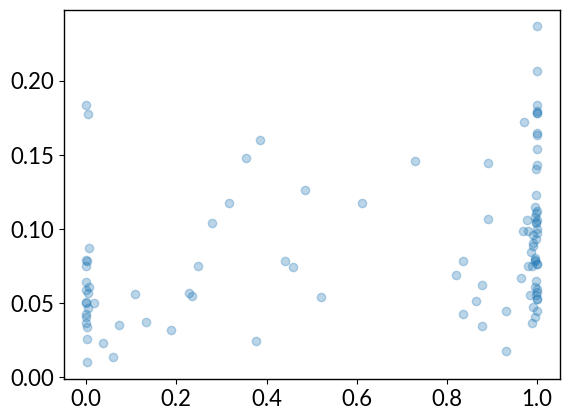

In [171]:
plt.scatter(dft_entropy,pca_e3nn,alpha=0.3)


In [128]:
pca_e3nn

[0.07901145073799141,
 0.14473956708345914,
 0.09838647743919614,
 0.104006254583688,
 0.14561393992644567,
 0.07476373730736802,
 0.10824159145774571,
 0.04997745305941368,
 0.04261404268656999,
 0.1629873578891955,
 0.07616649278273581,
 0.07866767833071985,
 0.10642900434085849,
 0.09752696724046421,
 0.08430114501448989,
 0.05580098532734503,
 0.15408866092811538,
 0.09879570381012187,
 0.23641888743350584,
 0.09030437653158781,
 0.044674280614883564,
 0.06080487508578542,
 0.05173039524517246,
 0.02425573297314519,
 0.080283576676639,
 0.05873732094904277,
 0.0748448941846075,
 0.04733218736400852,
 0.0961291954983972,
 0.05563077732350923,
 0.14310727697805306,
 0.11203626067643928,
 0.06900515537923231,
 0.037150655789220256,
 0.0782250725945595,
 0.1036813545401092,
 0.07516296146136146,
 0.06067308524984644,
 0.044994226605114145,
 0.17837214654475644,
 0.11779410633765423,
 0.04031231384307815,
 0.14746420371778365,
 0.16470251717374992,
 0.04979027286899782,
 0.1147521200197

In [129]:
pca_e3nn_args = np.argsort(pca_e3nn)

In [130]:
pca_e3nn_args

array([97, 60, 58, 72, 23, 76, 80, 57, 85, 86, 62, 96, 33, 41, 84, 75,  8,
       20, 38, 95, 27, 44,  7, 90, 22, 66, 54, 68, 99, 29, 15, 47, 69, 67,
       46, 25, 81, 37, 21, 59, 48, 74, 50, 32, 92,  5, 26, 36, 49, 10, 91,
       34, 79, 82, 11, 94,  0, 24, 14, 73, 77, 19, 52, 28, 13,  2, 17, 64,
       35,  3, 65, 70, 98, 12,  6, 61, 31, 45, 83, 40, 93, 88, 51, 30,  1,
        4, 42, 16, 89,  9, 43, 87, 56, 63, 39, 55, 78, 53, 71, 18])

Text(0, 0.5, 'PCA Spread')

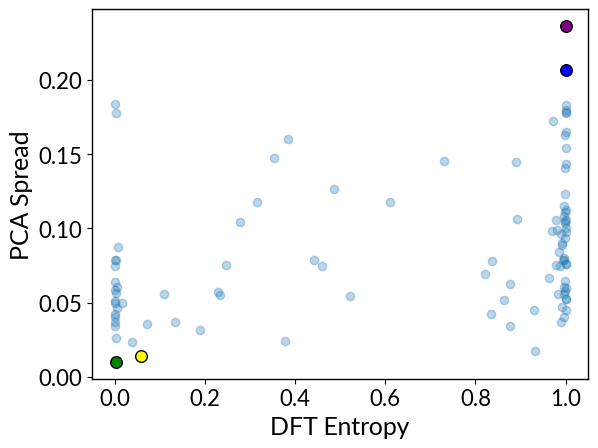

In [172]:
plt.scatter(dft_entropy,pca_e3nn,alpha=0.3)
sorted_pca = [x for _, x in sorted(zip(dft_entropy, pca_e3nn))]
dft_entropy_copy = dft_entropy[:]
dft_entropy_copy.sort()

data = [18, 71, 97, 60]

plt.scatter([dft_entropy[data[0]]],[pca_e3nn[data[0]]],color="purple",s=70,edgecolor="black")
plt.scatter([dft_entropy[data[1]]],[pca_e3nn[data[1]]],color="blue",s=70,edgecolor="black")
plt.scatter(dft_entropy[data[2]],pca_e3nn[data[2]],color="green",s=70,edgecolor="black")
plt.scatter(dft_entropy[data[3]],pca_e3nn[data[3]],color="yellow",s=70,edgecolor="black")

plt.xlabel("DFT Entropy",fontsize=18)
plt.ylabel("PCA Spread",fontsize=18)

In [133]:
np.corrcoef(dft_entropy,pca_e3nn)

array([[ 1.        , -0.36180695],
       [-0.36180695,  1.        ]])

In [19]:
def get_partitions(entropy,dist):
    
    small = []
    medium = []
    large = []
    
    for i in range(len(entropy)):
        if entropy[i]<0.25:
            small.append(dist[i])
        elif entropy[i]>0.75:
            large.append(dist[i])
        else:
            medium.append(dist[i])
    
    print(np.asarray(small).mean())
    print(np.asarray(medium).mean())
    print(np.asarray(large).mean())

In [20]:
get_partitions(dft_entropy,pca_CGCNN)

0.20756023724108516
0.22972423636820097
0.27622528939886076


In [21]:
get_partitions(dft_entropy,pca_e3nn)

0.10342036354601747
0.08289473416742271
0.05970362544556133


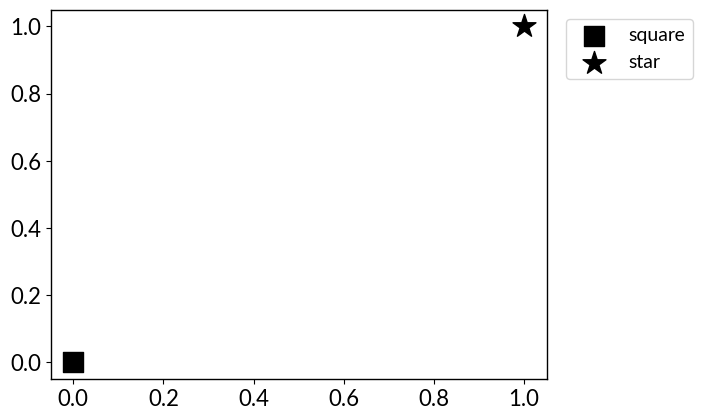

In [95]:
plt.scatter(0,0,marker="s",color="black",label="square",s = 200)
plt.scatter(1,1,marker="*",color="black",label="star",s=300)
plt.legend(bbox_to_anchor=(1.02, 1))
plt.savefig("figures/Star_ref.pdf",bbox_inches="tight")
plt.show()

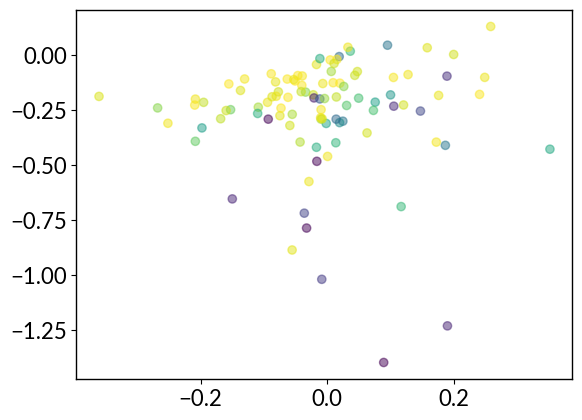

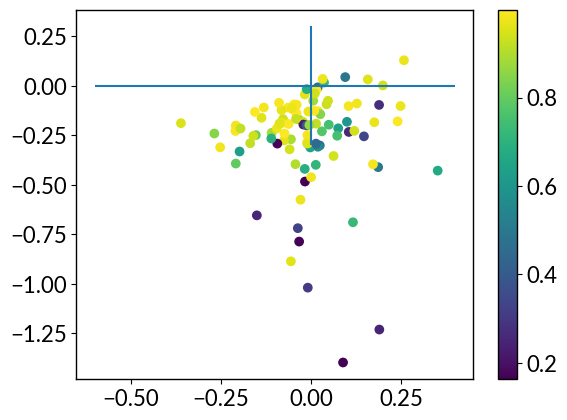

In [334]:
plt.scatter(CGCNN_vecs[:,0],CGCNN_vecs[:,1],c=CGCNN_entropy)
plt.colorbar()
plt.vlines(0.0,-0.3,0.3)
plt.hlines(0.0,-0.6,0.4)

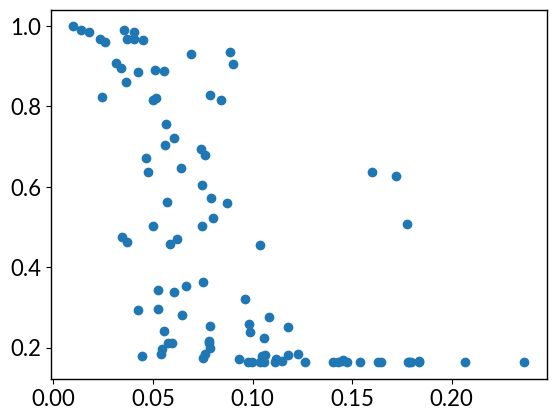

In [247]:
plt.scatter(pca_e3nn,dft_entropy)


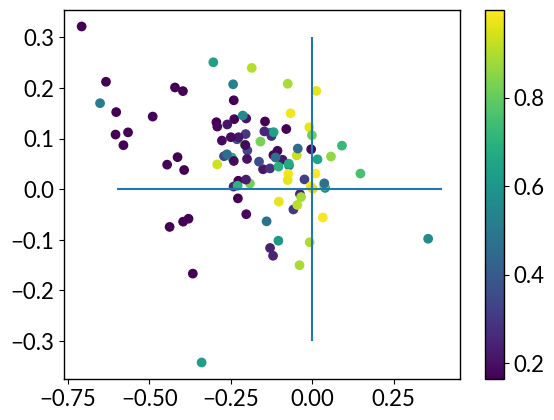

In [335]:
plt.scatter(e3nn_vecs[:,0],e3nn_vecs[:,1],c=e3nn_entropy)
plt.colorbar()
plt.vlines(0.0,-0.3,0.3)
plt.hlines(0.0,-0.6,0.4)

In [220]:
pca_e3nn_low = []
pca_e3nn_high = []

for i in range(100):
    if dft_entropy[i]<0.4:
        pca_e3nn_low.append(pca_e3nn[i,:])
    else:
        pca_e3nn_high.append(pca_e3nn[i,:])
        
pca_e3nn_low = np.asarray(pca_e3nn_low)
pca_e3nn_high = np.asarray(pca_e3nn_high)

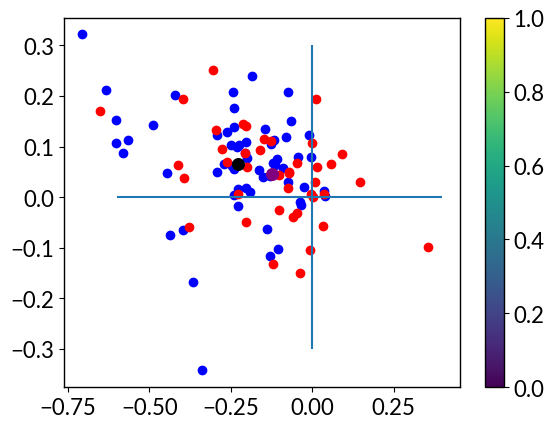

In [227]:
plt.scatter(pca_e3nn_low[:,0],pca_e3nn_low[:,1],color="blue")
plt.scatter(pca_e3nn_high[:,0],pca_e3nn_high[:,1],color="red")

plt.scatter(pca_e3nn_low[:,0].mean(),pca_e3nn_low[:,1].mean(),color="black",s=70)
plt.scatter(pca_e3nn_high[:,0].mean(),pca_e3nn_high[:,1].mean(),color="purple",s=70)

plt.colorbar()
plt.vlines(0.0,-0.3,0.3)
plt.hlines(0.0,-0.6,0.4)

In [281]:
formula_to_entropy_e3nn.items()

dict_items([('Ba8Mn4O24Ta4', 0.16469138004692874), ('Ca8Co4Fe4O24', 0.9908343054462045), ('Mn4O24Sr8U4', 0.6801646703090033), ('Ga4Nb4O24Sr8', 0.3529277897417157), ('Ba8O24Sb4Tl4', 0.1805679036762749), ('Hf4La8Mg4O24', 0.16813355242692332), ('Co4Ni4O24Sr8', 0.9674341558040664), ('La8Mg4O24Sn4', 0.9845843332302748), ('Mn4O24Pr8Ti4', 0.522262666749742), ('Ga4La8Ni4O24', 0.8608034296044321), ('O24Sc4Sr8Ta4', 0.17247675671753324), ('Mn4Ni4O24Pr8', 0.21155668533755564), ('O24Rh4Sr8Ta4', 0.6276688908832685), ('La4O24Sb4Sr8', 0.16511547660165216), ('In4O24Sr8Ta4', 0.16593560849460062), ('O24Ru4Sr8Y4', 0.16624054476059297), ('Ir4O24Sr8Zn4', 0.16317622715465482), ('Ca8Cr4O24Ta4', 0.9057007863350287), ('Ba8Fe4Nb4O24', 0.6046093524210138), ('Cr4O24Ru4Sr8', 0.6373715742204531), ('Mn4Ni4O24Sm8', 0.5720885009956652), ('Mn4O24Rh4Sm8', 0.5585865942533423), ('O24Ru4Sr8Ti4', 0.7046810184371796), ('La8Mn4O24Ti4', 0.8880027740607379), ('Ca8Cr4Nb4O24', 0.9351061459377489), ('Ca8Nb4O24V4', 0.886005734237428